Enter path to the folder:  C:\ARMADA
Percentile:  80
Outstanding Shareholder 5923000000


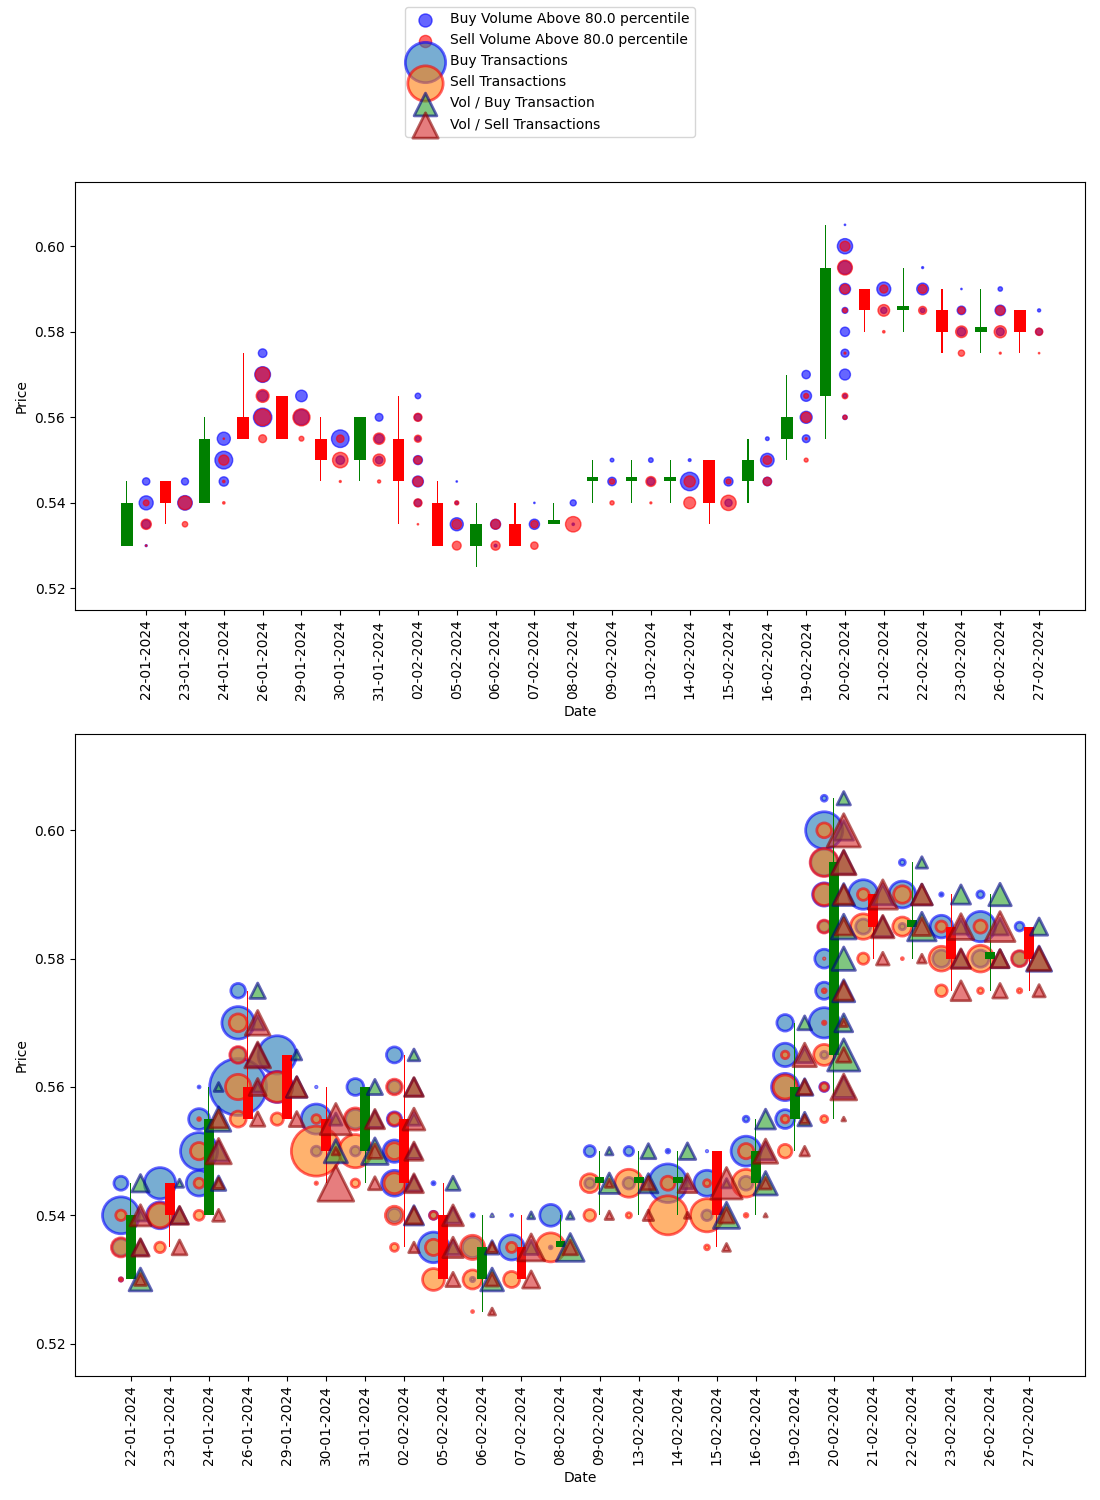

In [5]:
#!/usr/bin/env python
%matplotlib ipympl
from collections import OrderedDict
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
import csv
import os

if __name__ == '__main__':
    #path = r"C:\Users\MU036985\OneDrive\Desktop\StockAnalysis\LeForm"
    path = input("Enter path to the folder: ")
    os.chdir(path)    
    percentile = float(input ("Percentile: "))
    outstandingShareholder = float(input("Outstanding Shareholder"))
    buyDatePriceDictionary= {}
    sellDatePriceDictionary={}

    tempList = []
    tempListIndex = []
    for file in os.listdir():        
        with open(r"{}\{}".format(path, file), "r", encoding='utf-8') as csv_file:
            #rows = csv.DictReader(csv_file, delimiter=",")
            # Construct a list to determine percentile value
            dateString = file.removesuffix(".csv")
            dateObject = datetime.strptime(dateString, '%d-%m-%Y').date()
            df = pd.read_csv(csv_file)
            tempListIndex.append(dateObject)
            tempList.append([df.iat[0,2], df.iat[df['Price'].size-1, 2],  df['Price'].min(), df['Price'].max(), np.percentile(df['Vol']/outstandingShareholder, percentile)])

    
    dailyPriceStat = pd.DataFrame(tempList, columns = ['Open', 'Close', 'Low', 'High', 'PercentileValue'], index= tempListIndex )
   
         
    upDailyPriceStat = dailyPriceStat[dailyPriceStat.Close >= dailyPriceStat.Open] 
    downDailyPriceStat = dailyPriceStat[dailyPriceStat.Close < dailyPriceStat.Open] 
       


    buyDataPriceDictionary= {}
    buyDataVolumeDictionary = {}
    sellDataPriceDictionary={}
    sellDataVolumeDictionary = {}
    openDataPriceDictionary={}
    openDataVolumeDictionary = {}
    buyUniquePriceGlobalSet = set()
    sellUniquePriceGlobalSet = set()
    openUniquePriceGlobalSet = set()

    for (file, dailyStat) in zip(os.listdir(), dailyPriceStat["PercentileValue"]):        
        dateString = file.removesuffix(".csv")
        dateObject = datetime.strptime(dateString, '%d-%m-%Y').date()
        with open(r"{}\{}".format(path, file), "r", encoding='utf-8') as csv_file:
            rows = csv.DictReader(csv_file, delimiter=",") 
            buyAboveTresholdPrice = []
            sellAboveTresholdPrice = []

            buyPriceCountDictionary = {}
            buyPriceVolumeDictionary = {}
            sellPriceCountDictionary = {}
            sellPriceVolumeDictionary = {}
            openPriceCountDictionary = {}
            openPriceVolumeDictionary = {}
            buyUniquePriceSet = set()
            sellUniquePriceSet = set()
            openUniquePriceSet = set()
            
            for row in rows:  
                if(row["Type"] == 'B'):
                    if(float(row["Vol"])/outstandingShareholder >= float(dailyStat)):
                        buyAboveTresholdPrice.append(float(row["Price"]))
                        
                    if(buyUniquePriceSet.isdisjoint({float(row["Price"])})):
                        buyUniquePriceSet.add(float(row["Price"]))
                        buyPriceCountDictionary[float(row["Price"])] = 1
                        buyPriceVolumeDictionary[float(row["Price"])] = 0
                    else:
                        buyPriceCountDictionary[float(row["Price"])] = buyPriceCountDictionary[float(row["Price"])] + 1
                        buyPriceVolumeDictionary[float(row["Price"])] = buyPriceVolumeDictionary[float(row["Price"])] + float(row["Vol"])
                elif (row["Type"] == 'S'):
                    if(float(row["Vol"]) /outstandingShareholder >=  float(dailyStat)):
                        sellAboveTresholdPrice.append(float(row["Price"]))
                        
                    if(sellUniquePriceSet.isdisjoint({float(row["Price"])})):
                        sellUniquePriceSet.add(float(row["Price"]))
                        sellPriceCountDictionary[float(row["Price"])] = 1
                        sellPriceVolumeDictionary[float(row["Price"])] = 0
                    else:
                        sellPriceCountDictionary[float(row["Price"])] = sellPriceCountDictionary[float(row["Price"])] + 1
                        sellPriceVolumeDictionary[float(row["Price"])] = sellPriceVolumeDictionary[float(row["Price"])] + float(row["Vol"])
                elif(row["Type"] == 'O'):
                    if(openUniquePriceSet.isdisjoint({float(row["Price"])})):
                        openUniquePriceSet.add(float(row["Price"]))
                        openPriceCountDictionary[float(row["Price"])] = 1
                        openPriceVolumeDictionary[float(row["Price"])] = 0
                    else:
                        openPriceCountDictionary[float(row["Price"])] = openPriceCountDictionary[float(row["Price"])] + 1
                        openPriceVolumeDictionary[float(row["Price"])] = openPriceVolumeDictionary[float(row["Price"])] + float(row["Vol"])
                        
                    
            buyDatePriceDictionary[dateObject] = buyAboveTresholdPrice
            sellDatePriceDictionary[dateObject] = sellAboveTresholdPrice

            buyDataPriceDictionary[dateObject] = buyPriceCountDictionary
            sellDataPriceDictionary[dateObject] = sellPriceCountDictionary
            openDataPriceDictionary[dateObject] = openPriceCountDictionary
            buyDataVolumeDictionary[dateObject] = buyPriceVolumeDictionary
            sellDataVolumeDictionary[dateObject] = sellPriceVolumeDictionary
            openDataVolumeDictionary[dateObject] = openPriceVolumeDictionary
            buyUniquePriceGlobalSet.update(buyUniquePriceSet)
            sellUniquePriceGlobalSet.update(sellUniquePriceSet)
            openUniquePriceGlobalSet.update(openUniquePriceSet)
            #print(buyAboveTresholdPrice)
            #print(sellAboveTresholdPrice)
            
    fig = plt.figure()
    fig.set_figwidth(11)
    fig.set_figheight(15)
    spec = gridspec.GridSpec(ncols=1, nrows=3, height_ratios=[0.2, 2, 3])
    ax1 = fig.add_subplot(spec[1])
    
    datePosPercentileBuy = []
    datePosPercentileSell = []
    pricePosPercentileBuy = []
    pricePosPercentileSell = []
    bubblePosPercentileBuy = []
    bubblePosPercentileSell = []
    
    allDate = set()
    allDate.update(buyDatePriceDictionary.keys())
    allDate.update(sellDatePriceDictionary.keys())
    dateNumberMaping = {}
    for x, y in [(x, y) for x, y in zip(sorted(allDate), np.arange(len(allDate)))]:
        dateNumberMaping [x] = y

 
    #print(dateNumberMaping)
    
    upDays = [dateNumberMaping[x] for x in upDailyPriceStat.index]
    downDays = [dateNumberMaping[x] for x in downDailyPriceStat.index]
    #print(upDays)
    
      
    for bDate in buyDatePriceDictionary.keys():        
        for bPriceSet in set(buyDatePriceDictionary[bDate]):
            datePosPercentileBuy.append(dateNumberMaping[bDate])
            pricePosPercentileBuy.append(bPriceSet)
            bubblePosPercentileBuy.append(buyDatePriceDictionary[bDate].count(bPriceSet))
            

    for sDate in sellDatePriceDictionary.keys():
        for sPriceSet in set(sellDatePriceDictionary[sDate]):
            datePosPercentileSell.append(dateNumberMaping[sDate])
            pricePosPercentileSell.append(sPriceSet)
            bubblePosPercentileSell.append(sellDatePriceDictionary[sDate].count(sPriceSet))
            
    #plotting
    ##print([(x,y,z) for (x,y,z) in zip(datePosPercentileBuy, pricePosPercentileBuy, bubblePosPercentileBuy)])
    ##print([(x,y,z) for (x,y,z) in zip(datePosPercentileSell, pricePosPercentileSell, bubblePosPercentileSell)])
    
    ax1.scatter(datePosPercentileBuy, pricePosPercentileBuy, s=bubblePosPercentileBuy, c='blue' , alpha=0.6, label='Buy Volume Above {} percentile'.format( percentile))
    ax1.scatter(datePosPercentileSell, pricePosPercentileSell, s=bubblePosPercentileSell, c='red', alpha=0.6, label='Sell Volume Above {} percentile'.format(percentile))
    #ax1.scatter(datePosPercentileSell, pricePosPercentileSell, s=bubblePosPercentileSell, c='red', marker = '^', label='Sell Volume Above Threshold {} at percentile {}'.format(sellPercentileValue, percentile))
    ax1.set_xticks(list(dateNumberMaping.values()), [x.strftime("%d-%m-%Y") for x in dateNumberMaping.keys()], ha='center', rotation = 'vertical')
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Price")
    #negative
    col1 = 'green'
    #positive
    col2 = 'red'
    width = .3
    width2 = .03
    #ax4 = ax1.twinx()
    
    ax1.bar([x - 0.5 for x in upDays], [max(x,0.001) for x in upDailyPriceStat.Close-upDailyPriceStat.Open], width, bottom=upDailyPriceStat.Open, color=col1) 
    ax1.bar([x - 0.5 for x in upDays], upDailyPriceStat.High-upDailyPriceStat.Close, width2, bottom=upDailyPriceStat.Close, color=col1) 
    ax1.bar([x - 0.5 for x in upDays], upDailyPriceStat.Open-upDailyPriceStat.Low, width2, bottom=upDailyPriceStat.Low, color=col1) 
    ax1.bar([x - 0.5 for x in downDays], [min(x,-0.001) for x in downDailyPriceStat.Close-downDailyPriceStat.Open], width, bottom=downDailyPriceStat.Open, color=col2) 
    ax1.bar([x - 0.5 for x in downDays], downDailyPriceStat.High-downDailyPriceStat.Open, width2, bottom=downDailyPriceStat.Open, color=col2) 
    ax1.bar([x - 0.5 for x in downDays], downDailyPriceStat.Low-downDailyPriceStat.Close, width2, bottom=downDailyPriceStat.Close, color=col2) 
    ax1.set_ylim(bottom= min(dailyPriceStat['Low'])-0.01)
    ax1.set_ylim(top= max(dailyPriceStat['High'])+0.01)
    #fig.legend(loc='upper center')
    #plt.show()
    
    ax2 = fig.add_subplot(spec[2])
    datePosBuy = []
    datePosSell = []
    datePosOpen = []
    pricePosBuy = []
    pricePosSell = []
    pricePosOpen = []
    countPosBuy = []
    countPosSell = []
    countPosOpen = []
    volPerTranPosBuy = []
    volPerTranPosSell = []
    volPerTranPosOpen = []

    
    allDate = set()
    allDate.update(buyDataPriceDictionary.keys())
    allDate.update(sellDataPriceDictionary.keys())
    allDate.update(openDataPriceDictionary.keys())
    dateNumberMaping = {}
    for x, y in [(x, y) for x, y in zip(sorted(allDate), [2  + (x * 2) for x in range(0, len(allDate))])]:
        dateNumberMaping [x] = y
    
    upDays = [dateNumberMaping[x] for x in upDailyPriceStat.index]
    downDays = [dateNumberMaping[x] for x in downDailyPriceStat.index]
    
    for aDate in buyDataPriceDictionary.keys():        
        for aPrice in buyDataPriceDictionary[aDate]:
            datePosBuy.append(dateNumberMaping[aDate])
            pricePosBuy.append(float(aPrice))
            #pricePosBuy.append(priceNumberMaping[aPrice])
            countPosBuy.append(buyDataPriceDictionary[aDate][aPrice])   
            volPerTranPosBuy.append(float(buyDataVolumeDictionary[aDate][aPrice] / buyDataPriceDictionary[aDate][aPrice]))

        
    for sDate in sellDataPriceDictionary.keys():
        for sPrice in sellDataPriceDictionary[sDate]:
            datePosSell.append(dateNumberMaping[sDate])
            pricePosSell.append(float(sPrice))
            #pricePosSell.append(priceNumberMaping[sPrice])
            countPosSell.append(sellDataPriceDictionary[sDate][sPrice])
            volPerTranPosSell.append(float(sellDataVolumeDictionary[sDate][sPrice] / sellDataPriceDictionary[sDate][sPrice]))

    for oDate in openDataPriceDictionary.keys():
            for oPrice in openDataPriceDictionary[oDate]:
                datePosOpen.append(dateNumberMaping[oDate])
                pricePosOpen.append(float(oPrice))
                #pricePosOpen.append(priceNumberMaping[oPrice])
                countPosOpen.append(openDataPriceDictionary[oDate][oPrice])  
                volPerTranPosOpen.append(float(openDataVolumeDictionary[oDate][oPrice] / openDataPriceDictionary[oDate][oPrice]))    
    
    ax2.scatter([x - 0.50 for x in datePosBuy], pricePosBuy, s=countPosBuy, edgecolors='blue', alpha=0.6, linewidths=2, label='Buy Transactions') # Buy
    ax2.scatter([x - 0.50 for x in datePosSell], pricePosSell, s=countPosSell,  edgecolors='red', alpha=0.6, linewidths=2, label='Sell Transactions') # Sell
    #ax1.scatter([x - 0.5 for x in datePosOpen], pricePosOpen, s=countPosOpen, alpha=0.6, edgecolors='darkyellow', linewidths=2, label='Open Transactions') # Open
    width = .5
    width2 = .05
    
    ax2.bar(upDays, [max(x,0.001) for x in upDailyPriceStat.Close-upDailyPriceStat.Open], width, bottom=upDailyPriceStat.Open, color=col1) 
    ax2.bar(upDays, upDailyPriceStat.High-upDailyPriceStat.Close, width2, bottom=upDailyPriceStat.Close, color=col1) 
    ax2.bar(upDays, upDailyPriceStat.Open-upDailyPriceStat.Low, width2, bottom=upDailyPriceStat.Low, color=col1) 
    ax2.bar(downDays, [min(x,-0.001) for x in downDailyPriceStat.Close-downDailyPriceStat.Open], width, bottom=downDailyPriceStat.Open, color=col2) 
    ax2.bar(downDays, downDailyPriceStat.High-downDailyPriceStat.Open, width2, bottom=downDailyPriceStat.Open, color=col2) 
    ax2.bar(downDays, downDailyPriceStat.Low-downDailyPriceStat.Close, width2, bottom=downDailyPriceStat.Close, color=col2)
    
    ax2.set_xticks(list(dateNumberMaping.values()), [x.strftime("%d-%m-%Y") for x in dateNumberMaping.keys()], ha='center', rotation = 'vertical')
    #ax2.set_yticks(list(priceNumberMaping.values()), priceNumberMaping.keys(), ha='right')
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Price")    
  
    ax2.scatter([x + 0.50 for x in datePosBuy], pricePosBuy, s=volPerTranPosBuy, edgecolors='darkblue', alpha=0.6, linewidths=2, label='Vol / Buy Transaction', marker = '^') # Buy
    ax2.scatter([x + 0.50 for x in datePosSell], pricePosSell, s=volPerTranPosSell,  edgecolors='darkred', alpha=0.6, linewidths=2, label='Vol / Sell Transactions', marker = '^') # Sell
    #ax2.scatter([x + 0.5 for x in datePosOpen], pricePosOpen, s=volPerTranPosOpen, alpha=0.6, edgecolors='darkyellow', linewidths=2, label='Vol / Open Transactions', marker = '^') # Open
    ax2.set_ylim(bottom= min(dailyPriceStat['Low'])-0.01)
    ax2.set_ylim(top= max(dailyPriceStat['High'])+0.01)
    fig.tight_layout()
    fig.legend(loc="upper center")

    ##print([ (x.strftime("%d-%m-%Y"), y) for (x, y) in zip(dateNumberMaping.keys(), dailyPriceStat['PercentileValue'])])
    plt.show()
   
    
